In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import string
import seaborn as sns
import scipy as sp
from toydown import GeoUnit, ToyDown
# from matplotlib import rc
# rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)

## Functions to Create Demo Trees

In [2]:
def create_tree_from_leaves(leaf_dict):
    """ Given a dictionary, where the keys are the names of leaf nodes (labeled by their path)
        and the corresponding value is the associated attribute counts, this function returns
        the list of GeoUnits that defines the corresponding tree.
    """
    nodes = leaf_dict.copy()
    h = len(list(leaf_dict.keys())[0])
    n = len(list(leaf_dict.values())[0])
    
    for i in range(2, h+1):
        level_names = list(set(list(map(lambda s: s[:-(i-1)], leaf_dict.keys()))))
        level_counts = [np.zeros(n)]*len(level_names)
        for node in level_names:
            nodes[node] = np.array([v for k, v in leaf_dict.items() if k.startswith(node)]).sum(axis=0)
        
    return [GeoUnit(k, k[:-1], v) if k != "1" else GeoUnit(k, None, v) for k, v in nodes.items()]

In [3]:
def create_demo_tree_homogenous_branching(h=3, k=2):
    """ Creates a demo tree of height h <= 16, with homogenous branching of h.
        This demo tree has two population counts, and count that is the sum of them.
    """
    leaves = ["1" + "".join(a) for a in itertools.product(string.hexdigits[1:h+1], repeat=h-1)]
    leaves_counts = np.random.randint(1000, size=(len(leaves),k))
    leaves_attrs = np.insert(leaves_counts, 0, leaves_counts.sum(axis=1), axis=1)
    
    leaf_dict = {i: j for i, j in zip(leaves, leaves_attrs)}
    return create_tree_from_leaves(leaf_dict)

In [4]:
def create_demo_er_tree(h=3):
    leaves = ["1" + "".join(a) for a in itertools.product(string.hexdigits[1:h+1], repeat=h-1)]
    num_leaves = len(leaves)
    a = np.linspace(0, 100, num_leaves)  + np.random.uniform(0,100,num_leaves)
    b = np.flipud(np.linspace(0, 200, num_leaves) + np.random.uniform(0,100,num_leaves))
    leaves_counts = np.stack((a,b), axis=-1)
    leaves_attrs = np.insert(leaves_counts, 0, leaves_counts.sum(axis=1), axis=1)
    
    leaf_dict = {i: j for i, j in zip(leaves, leaves_attrs)}
    return create_tree_from_leaves(leaf_dict)

## Set-up ToyDown Model

In [5]:
leaves = {'133': np.array([152.01127753, 138.84528446,  13.16599307]),
          '132': np.array([212.33036409, 161.9876171 ,  50.34274699]),
          '131': np.array([200.25783133, 120.10254376,  80.15528757]),
          '123': np.array([279.75309343, 116.00477968, 163.74831374]),
          '122': np.array([294.78230712, 100.31018182, 194.4721253 ]),
          '121': np.array([290.33488693, 112.70811816, 177.62676877]),
          '113': np.array([261.15279716, 102.36320046, 158.78959671]),
          '112': np.array([367.09928003, 101.20197765, 265.89730238]),
          '111': np.array([345.7709206 ,  60.39187144, 285.37904916])}

leaf_names = ["1" + "".join(a) for a in itertools.product(string.hexdigits[1:3+1], repeat=3-1)]

In [6]:
geounits = create_tree_from_leaves(leaves)
geounits.reverse()
eps = 0.2
eps_split = [1/3, 1/3, 1/3]#[0.25, 0.25, 0.5]

In [7]:
model = ToyDown(geounits, 3, eps, eps_split)
model.show()

1
├── 11
│   ├── 111
│   ├── 112
│   └── 113
├── 12
│   ├── 121
│   ├── 122
│   └── 123
└── 13
    ├── 131
    ├── 132
    └── 133



In [8]:
cons_0_diff = lambda n: [{'type': 'eq', 'fun': lambda x, i=i:  x[i] - np.sum([x[j] for j in range(i+1,i+3)])} 
                         for i in np.arange(n*3, step=3)]

In [9]:
# model.noise_and_adjust(node_cons=cons_0_diff, verbose=True)

## Noising leaves vs. ToyDown noise

In [10]:
# leaves = ["1" + "".join(a) for a in itertools.product(string.hexdigits[1:3+1], repeat=3-1)]

In [11]:
def leaf_counts(leaves, model):
    num_leaves = len(leaves)
    counts = np.zeros((num_leaves,3))
    for i,l in enumerate(leaves):
        counts[i] = model.get_node(l).data.attributes
    return counts

In [12]:
def noise_leaves_sep(counts, cols, scale, sum_initial=True, noise_type="gaussian"):
    n = len(counts)
    noise = np.zeros((n,3))
    
    if noise_type == "gaussian":
        noise[:,cols] = np.random.normal(0, scale,(n, len(cols)))
    elif noise_type == "laplace":
        noise[:,cols] = np.random.laplace(0, scale,(n, len(cols)))
    else:
        raise ValueError("noise_type '{}' is not recognized".format(noise_type))
    noised_counts = counts + noise
    if sum_initial: noised_counts[:,0] = noised_counts[:,1:].sum(axis=1)
    return noised_counts

In [13]:
def toydown_noise(leaves, model, cons=cons_0_diff, n_leaves=None):
    n = n_leaves if n_leaves else len(leaves)
    noised_counts = np.zeros((n,3))
    model.noise_and_adjust(node_cons=cons)
    for i,l in enumerate(leaves):
        noised_counts[i] = model.get_node(l).data.adjusted
    return noised_counts

In [14]:
counts = leaf_counts(leaf_names, model)
perc_A = counts[:,1] / counts[:,0]

In [15]:
perc_vote_for_X = np.array([ 0.15645235, 0.20648465, 0.23917829, 0.44568536, 0.51541049, 0.68753399, 0.73400675, 0.82867988, 0.89909448])##np.linspace(0.1,0.9,9) + np.random.normal(0, 0.05)
line = sp.stats.linregress(perc_A, perc_vote_for_X)
l = np.poly1d([line.slope, line.intercept])

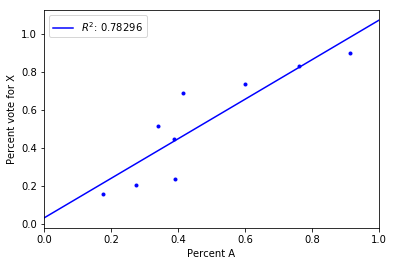

In [16]:
xp = np.linspace(0, 1, 100)
plt.xlabel("Percent A")
plt.ylabel("Percent vote for X")
plt.xlim(0,1)
# plt.ylim(0,1)
plt.plot(perc_A, perc_vote_for_X, '.', color="b")
plt.plot(xp, l(xp), '-', color="b", label="$R^2$: {}".format(round(line.rvalue**2,5)))
plt.legend()
plt.show()

In [17]:
counts - noise_leaves_sep(counts, [1,2], 1)

array([[-0.99828198, -0.65615403, -0.34212794],
       [ 2.56711848,  0.87369164,  1.69342684],
       [ 1.56344994,  0.34861203,  1.21483793],
       [ 0.08119619,  0.06979216,  0.01140403],
       [-0.67067127, -1.7133847 ,  1.04271342],
       [-0.1368413 ,  1.16570291, -1.30254422],
       [ 0.86745758,  0.29012695,  0.57733063],
       [-1.3679653 , -0.49852507, -0.86944023],
       [ 0.93921606, -0.16868515,  1.10790121]])

In [18]:
counts - noise_leaves_sep(counts, [1,2], 50)

array([[ 189.5029202 ,  102.94682058,   86.55609962],
       [ -12.62016611,  -20.00240791,    7.3822418 ],
       [  -9.32785002,  -62.29974702,   52.97189701],
       [ -49.64829065, -142.33855222,   92.69026157],
       [-128.24830621,  -92.89980598,  -35.34850023],
       [ 104.43024474,   48.12080675,   56.30943798],
       [  -4.49345258,   98.46470852, -102.9581611 ],
       [   9.66997883,  -50.56090631,   60.23088515],
       [ -30.86462839,   34.3941695 ,  -65.25879789]])

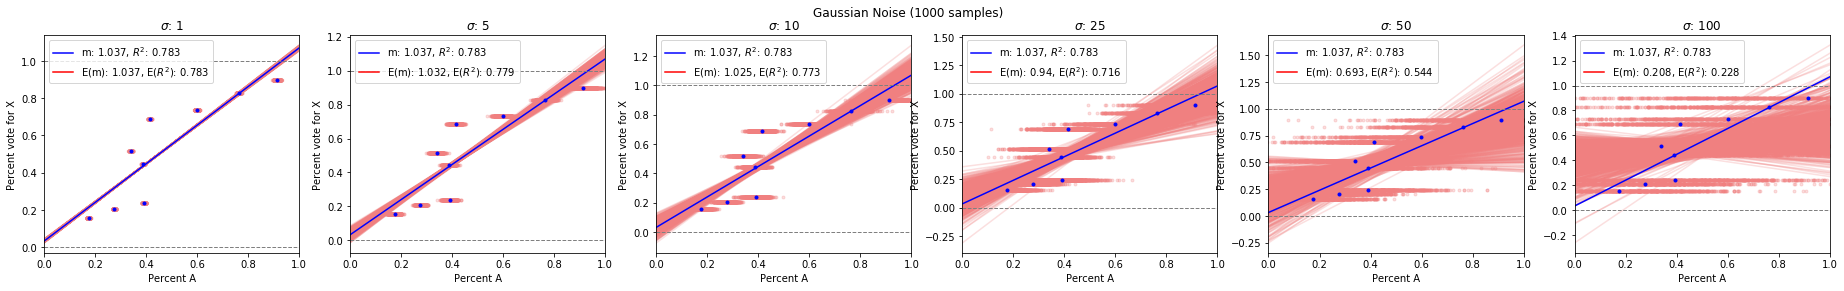

In [19]:
n_samps = 1000
sds = [1, 5, 10, 25, 50, 100]
rs_noised = np.zeros((len(sds), n_samps))
ms_noised = np.zeros((len(sds), n_samps))
xp = np.linspace(0, 1, 100)

fig, axs = plt.subplots(1, len(sds), figsize=(32,4))

for j, sd in enumerate(sds):
    for i in range(n_samps):
        noised_counts = noise_leaves_sep(counts, [1,2], sd)
        perc_A_noised = noised_counts[:,1] / noised_counts[:,0]
        line_noised = sp.stats.linregress(perc_A_noised, perc_vote_for_X)
        l_n = np.poly1d([line_noised.slope, line_noised.intercept])

        axs[j].plot(perc_A_noised, perc_vote_for_X, '.', color="lightcoral", alpha=0.25)
        axs[j].plot(xp, l_n(xp), '-', color="lightcoral", alpha=0.25)

        rs_noised[j,i] = line_noised.rvalue
        ms_noised[j,i] = line_noised.slope

    axs[j].plot(perc_A, perc_vote_for_X, '.', color="b")
    axs[j].plot(xp, l(xp), '-', color="b", label="m: {}, $R^2$: {}".format(round(line.slope, 3), round(line.rvalue**2,3)))

    axs[j].plot([], [], '-', color="r", label="E(m): {}, E($R^2$): {}".format(round(np.mean(ms_noised[j]),3), 
                                                                         round(np.mean(rs_noised[j]**2),3)))

    axs[j].set_xlabel("Percent A")
    axs[j].set_ylabel("Percent vote for X")
    axs[j].set_xlim(0,1)
    axs[j].axhline(0, ls="dashed", c="grey", linewidth=1)
    axs[j].axhline(1, ls="dashed", c="grey", linewidth=1)
    axs[j].legend()
    axs[j].set_title("$\sigma$: {}".format(sd))
fig.suptitle("Gaussian Noise ({} samples)".format(n_samps))
plt.savefig("plots/ER_adding_gaussian_noise_{}_samps.png".format(n_samps), dpi=200)
plt.show()

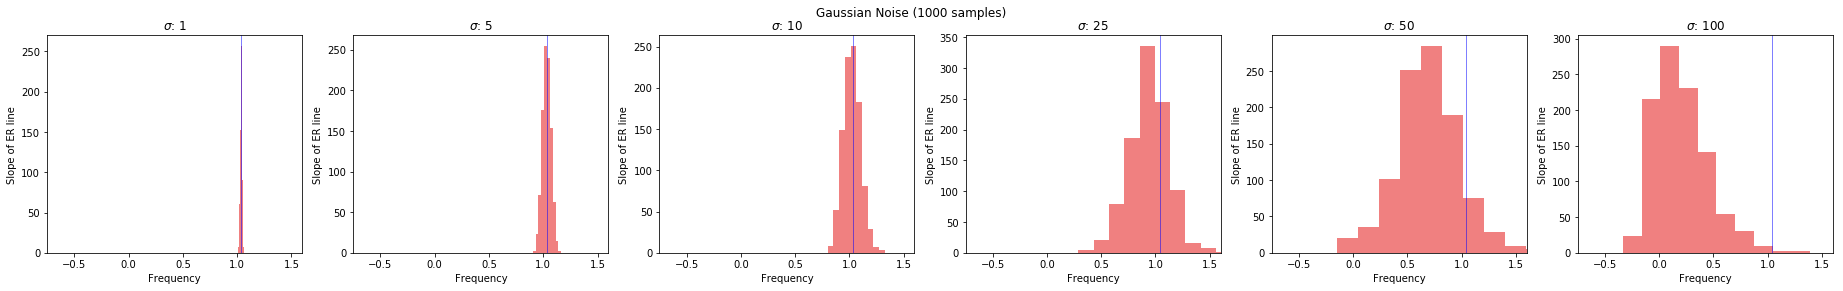

In [20]:
fig, axs = plt.subplots(1, len(sds), figsize=(32,4))

for j, sd in enumerate(sds):

    axs[j].hist(ms_noised[j], color="lightcoral")
    axs[j].axvline(line.slope, color="b", linewidth=0.5)
    axs[j].set_xlim(-0.75, 1.6)
    axs[j].set_xlabel("Frequency")
    axs[j].set_ylabel("Slope of ER line")
#     axs[j].legend()
    axs[j].set_title("$\sigma$: {}".format(sd))
fig.suptitle("Gaussian Noise ({} samples)".format(n_samps))
plt.savefig("plots/ER_adding_gaussian_noise_{}_samps_hists.png".format(n_samps), dpi=200)
plt.show()

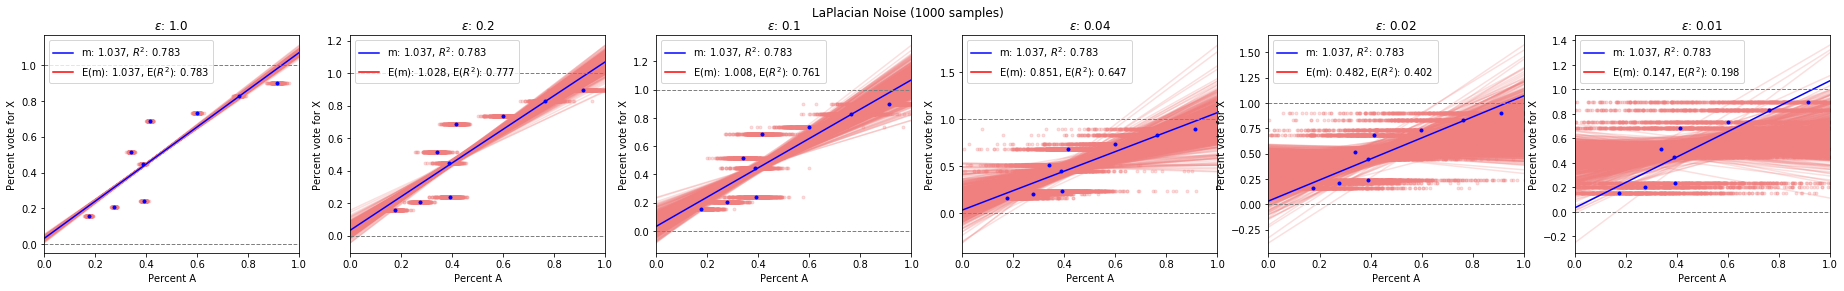

In [21]:
n_samps = 1000
sds = [1, 5, 10, 25, 50, 100]
rs_noised = np.zeros((len(sds), n_samps))
ms_noised = np.zeros((len(sds), n_samps))
xp = np.linspace(0, 1, 100)

fig, axs = plt.subplots(1, len(sds), figsize=(32,4))

for j, sd in enumerate(sds):
    for i in range(n_samps):
        noised_counts = noise_leaves_sep(counts, [1,2], sd, noise_type="laplace")
        perc_A_noised = noised_counts[:,1] / noised_counts[:,0]
        line_noised = sp.stats.linregress(perc_A_noised, perc_vote_for_X)
        l_n = np.poly1d([line_noised.slope, line_noised.intercept])

        axs[j].plot(perc_A_noised, perc_vote_for_X, '.', color="lightcoral", alpha=0.25)
        axs[j].plot(xp, l_n(xp), '-', color="lightcoral", alpha=0.25)

        rs_noised[j,i] = line_noised.rvalue
        ms_noised[j,i] = line_noised.slope

    axs[j].plot(perc_A, perc_vote_for_X, '.', color="b")
    axs[j].plot(xp, l(xp), '-', color="b", label="m: {}, $R^2$: {}".format(round(line.slope, 3), round(line.rvalue**2,3)))

    axs[j].plot([], [], '-', color="r", label="E(m): {}, E($R^2$): {}".format(round(np.mean(ms_noised[j]),3), 
                                                                         round(np.mean(rs_noised[j]**2),3)))

    axs[j].set_xlabel("Percent A")
    axs[j].set_ylabel("Percent vote for X")
    axs[j].set_xlim(0,1)
    axs[j].axhline(0, ls="dashed", c="grey", linewidth=1)
    axs[j].axhline(1, ls="dashed", c="grey", linewidth=1)
    axs[j].legend()
    axs[j].set_title("$\epsilon$: {}".format(1/sd))
fig.suptitle("LaPlacian Noise ({} samples)".format(n_samps))
plt.savefig("plots/ER_adding_laplace_noise_{}_samps.png".format(n_samps), dpi=200)
plt.show()

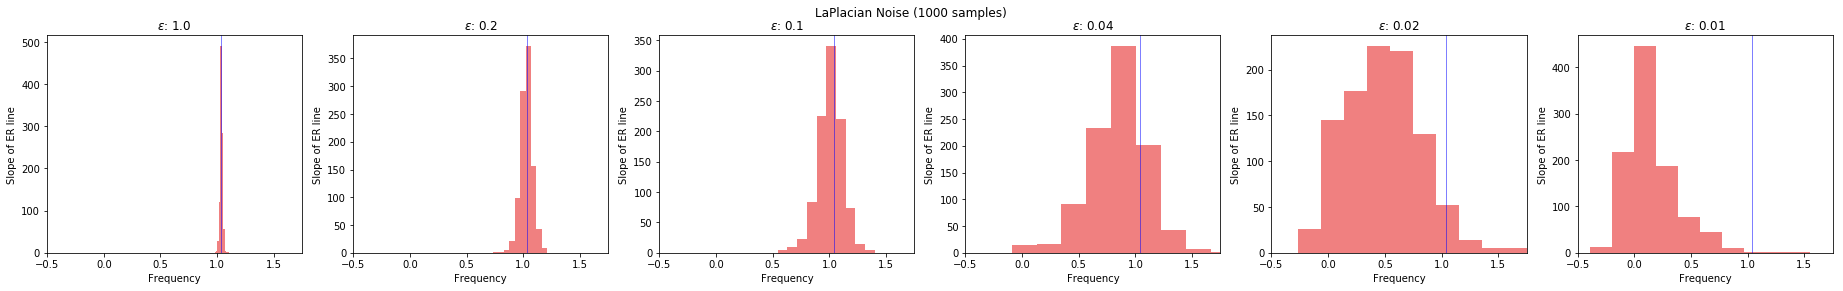

In [22]:
fig, axs = plt.subplots(1, len(sds), figsize=(32,4))

for j, sd in enumerate(sds):

    axs[j].hist(ms_noised[j], color="lightcoral")
    axs[j].axvline(line.slope, color="b", linewidth=0.5)
    axs[j].set_xlim(-0.5, 1.75)
    axs[j].set_xlabel("Frequency")
    axs[j].set_ylabel("Slope of ER line")
#     axs[j].legend()
    axs[j].set_title("$\epsilon$: {}".format(1/sd))
fig.suptitle("LaPlacian Noise ({} samples)".format(n_samps))
plt.savefig("plots/ER_adding_laplace_noise_{}_samps_hists.png".format(n_samps), dpi=200)
plt.show()

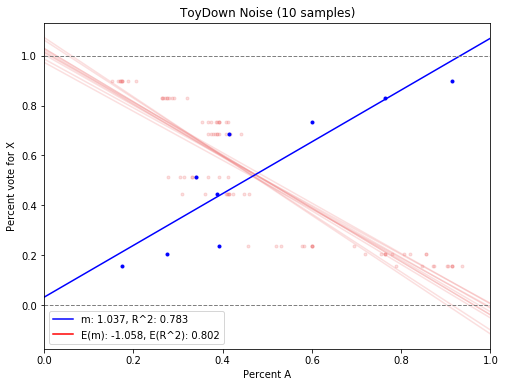

In [23]:
n_samps = 10
rs_noised = np.zeros(n_samps)
ms_noised = np.zeros(n_samps)
xp = np.linspace(0, 1, 100)

plt.figure(figsize=(8,6))

for i in range(n_samps):
    noised_counts = toydown_noise(leaves, model, n_leaves=9)
    perc_A_noised = noised_counts[:,1] / noised_counts[:,0]
    line_noised = sp.stats.linregress(perc_A_noised, perc_vote_for_X)
    l_n = np.poly1d([line_noised.slope, line_noised.intercept])
    
    plt.plot(perc_A_noised, perc_vote_for_X, '.', color="lightcoral", alpha=0.25)
    plt.plot(xp, l_n(xp), '-', color="lightcoral", alpha=0.25)
    
    rs_noised[i] = line_noised.rvalue
    ms_noised[i] = line_noised.slope
    
plt.plot(perc_A, perc_vote_for_X, '.', color="b")
plt.plot(xp, l(xp), '-', color="b", label="m: {}, R^2: {}".format(round(line.slope, 3), round(line.rvalue**2,3)))

plt.plot([], [], '-', color="r", label="E(m): {}, E(R^2): {}".format(round(np.mean(ms_noised),3), 
                                                                     round(np.mean(rs_noised**2),3)))

plt.xlabel("Percent A")
plt.ylabel("Percent vote for X")
plt.xlim(0,1)
plt.axhline(0, ls="dashed", c="grey", linewidth=1)
plt.axhline(1, ls="dashed", c="grey", linewidth=1)
plt.title("ToyDown Noise ({} samples)".format(n_samps))
plt.legend()
# plt.savefig("plots/ER_adding_toydown_noise_{}_samps.png".format(n_samps), dpi=200)
plt.show()

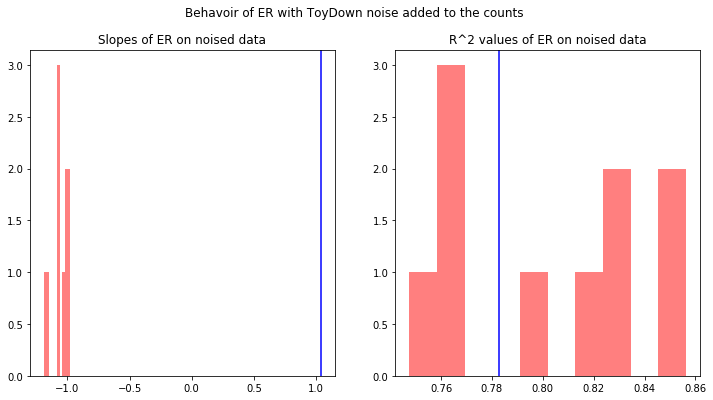

In [24]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].hist(ms_noised, color="red", alpha=0.5)
axs[0].axvline(line.slope, color="b")
axs[1].hist(rs_noised**2, color="red", alpha=0.5)
axs[1].axvline(line.rvalue**2, color="b")

axs[0].set_title("Slopes of ER on noised data")
axs[1].set_title("R^2 values of ER on noised data")
fig.suptitle("Behavoir of ER with ToyDown noise added to the counts")
# plt.savefig("plots/ER_adding_toydown_noise_hists_{}_samps.png".format(n_samps), dpi=200)
fig.show()

In [25]:
# sns.regplot(perc_A, perc_vote_for_X)
# sns.regplot(perc_A_noised, perc_vote_for_X)
# plt.show()